In [1]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

In [2]:
# %load datasets_generator.py
import os.path

import dgl

import data_helper
import landmarks
import node2vec
from data_helper import read_file
import utilities

def create_train_val_test_sets(file_name, force_recreate_datasets, write_train_val_test,portion,method):
    final_output_path = f"../output/datasets/{file_name}_train_val_test.pkl"

    if not force_recreate_datasets and os.path.isfile(final_output_path):  ## if the file already exists
        print(f"datasets for '{file_name}' already exists, only read them back!")
        return read_file(final_output_path)

    # TODO: should keep the config in one separate file
    ##### Step 1. Read data
    ## `file_name` is an edgelist file, no extension needed
    # "small_test" is a small dataset for testing, default data should be "socfb-American75"
    # file_name: {"ego-facebook-original", "small_test", "socfb-American75", ...}

    ## Load input file into a DGL graph
    input_path = f"../data/{file_name}.edgelist"
    graph = data_helper.load_edgelist_file_to_dgl_graph(path=input_path, undirected=True,
                                                        edge_weights=None)

    #####  Step 2. Run Node2Vec to get the embedding
    # Node2Vec params
    node2vec_args = {
        "device": "cuda",
        "embedding_dim": 128,
        "walk_length": 5,  # 80
        "window_size": 5,  # 10
        "p": 0.2,  # 0.25,
        "q": 4,  # 4.0,
        "num_walks": 25,
        "epochs": 100,  # 100
        "batch_size": 128,
        "learning_rate": 0.01,
    }
    embedding_output_path = f"../output/embedding/{file_name}_embed.pkl"
    if(os.path.isfile(embedding_output_path)):
        embedding = read_file(embedding_output_path)
    # took ~6mins/epoch to get Node2Vec for "socfb-American75", using 8GB RAM, 4CPU Macbook
    else:
        embedding = node2vec.run_node2vec(graph, eval_set=None, args=node2vec_args, output_path=embedding_output_path)
    print(f"Done embedding {file_name}!")
    nx_graph = dgl.to_networkx(graph)
    if(method == 'random'):
        ## Option 1: Get a few landmark nodes randomly from the graph:
        random_seed = 2021
        num_landmarks = int(len(nx_graph)*portion)
        landmark_nodes = landmarks.get_landmark_nodes(num_landmarks, nx_graph, random_seed=random_seed)
    else:
        ##Get customize landmark nodes 
        landmark_nodes = landmarks.get_landmark_custom(nx_graph,portion = portion)
        
    #####  Step 3: Create labels:
    # We convert the `dgl` graph to `networkx` graph. We will use networkx for finding the shortest path
    

    

    ## Option 2: set `num_landmarks` to `graph.num_nodes()` to make all the nodes as landmark nodes.
    ## TODO: when all nodes are landmark nodes, might need a better way to calc the distance (symmetric matrix)
    # num_landmarks = nx_graph.number_of_nodes()
    
    
    ## Get landmark nodes:
   
    
   
    
    # Get landmarks' distance: get distance of every pair (l,n), where l is a landmark node, n is a node in the graph
    landmark_distance_output = f"../output/landmarks_distance/{file_name}_dist.pkl"  # where to store the output file
    print("Calculating landmarks distance...")
    distance_map = landmarks.calculate_landmarks_distance(landmark_nodes, nx_graph,
                                                          output_path=landmark_distance_output)
    print("Done landmarks distance!")

    ## Plot the network
    ##utilities.plot_nx_graph(nx_graph, file_name=file_name)

    ##### Step 4: Create datasets to train a model
    print("creating datasets...")
    x, y = data_helper.create_dataset(distance_map, embedding)
    x, y = data_helper.remove_data_with_a_few_observations(x, y)
    test_size = 0.25
    val_size = 0.15
    train_val_test_path = "../output/datasets"
    datasets = data_helper.train_valid_test_split(x, y, test_size=test_size, val_size=val_size,
                                                  output_path=train_val_test_path,
                                                  file_name=file_name, write_train_val_test=write_train_val_test,random_seed = 2021)
    return datasets
hide_toggle()

Using backend: pytorch


In [53]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import accuracy_score,mean_absolute_error

In [79]:
def poisson_loss(y_true, y_pred):
            """
            Custom loss function for Poisson model.
            Equivalent Keras implementation for reference:
            K.mean(y_pred - y_true * math_ops.log(y_pred + K.epsilon()), axis=-1)
            For output of shape (2,3) it return (2,) vector. Need to calculate
            mean of that too.
            """
            y_pred = tf.squeeze(y_pred)
            loss = tf.reduce_mean(y_pred - y_true * tf.math.log(y_pred+1e-7),axis=-1)
#             y_pred = torch.squeeze(y_pred)
#             loss = torch.mean(y_pred - y_true * torch.log(y_pred+1e-7))
            return loss

def cons_model():
    
    model = tf.keras.models.Sequential()
    """    
    """
    model.add(tf.keras.layers.Dense(200))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Dense(100))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Dense(50))
    model.add(tf.keras.layers.BatchNormalization())
    model.add(tf.keras.layers.ReLU())
    model.add(tf.keras.layers.Dense(1,activation = 'softplus'))
    
#     model.add(tf.keras.layers.Conv2D(filters=1, kernel_size=(1, 1),activation='sigmoid',padding='same', data_format='channels_last')) 
    model.build((None,128))
    print(model.summary())
    return model

my_model = cons_model()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 200)               25800     
                                                                 
 batch_normalization_25 (Bat  (None, 200)              800       
 chNormalization)                                                
                                                                 
 re_lu_24 (ReLU)             (None, 200)               0         
                                                                 
 dense_34 (Dense)            (None, 100)               20100     
                                                                 
 batch_normalization_26 (Bat  (None, 100)              400       
 chNormalization)                                                
                                                                 
 re_lu_25 (ReLU)             (None, 100)             

In [80]:
my_model.compile(loss=poisson_loss, optimizer=tf.keras.optimizers.RMSprop(
    learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07, centered=False,name='RMSprop'))

In [81]:
my_train = my_model.fit(x_train, y_train, batch_size=1000,epochs=100,verbose=1,validation_data=(x_valid, y_valid))

Epoch 1/100
116/116 [==============================] - 1s 5ms/step - loss: -1.7712 - val_loss: -1.9698
Epoch 2/100
116/116 [==============================] - 1s 4ms/step - loss: -3.1596 - val_loss: -3.0367
Epoch 3/100
116/116 [==============================] - 0s 4ms/step - loss: -3.1872 - val_loss: -3.1624
Epoch 4/100
116/116 [==============================] - 1s 5ms/step - loss: -3.1885 - val_loss: -3.1826
Epoch 5/100
116/116 [==============================] - 1s 4ms/step - loss: -3.1891 - val_loss: -3.1863
Epoch 6/100
116/116 [==============================] - 0s 4ms/step - loss: -3.1893 - val_loss: -3.1790
Epoch 7/100
116/116 [==============================] - 0s 4ms/step - loss: -3.1896 - val_loss: -3.1880
Epoch 8/100
116/116 [==============================] - 0s 4ms/step - loss: -3.1897 - val_loss: -3.1861
Epoch 9/100
116/116 [==============================] - 0s 4ms/step - loss: -3.1898 - val_loss: -3.1870
Epoch 10/100
116/116 [==============================] - 0s 4ms/step - los

Epoch 80/100
116/116 [==============================] - 0s 4ms/step - loss: -3.1906 - val_loss: -3.1899
Epoch 81/100
116/116 [==============================] - 0s 4ms/step - loss: -3.1905 - val_loss: -3.1899
Epoch 82/100
116/116 [==============================] - 0s 4ms/step - loss: -3.1906 - val_loss: -3.1897
Epoch 83/100
116/116 [==============================] - 0s 4ms/step - loss: -3.1906 - val_loss: -3.1901
Epoch 84/100
116/116 [==============================] - 0s 4ms/step - loss: -3.1906 - val_loss: -3.1901
Epoch 85/100
116/116 [==============================] - 1s 5ms/step - loss: -3.1907 - val_loss: -3.1900
Epoch 86/100
116/116 [==============================] - 0s 4ms/step - loss: -3.1906 - val_loss: -3.1893
Epoch 87/100
116/116 [==============================] - 1s 5ms/step - loss: -3.1906 - val_loss: -3.1900
Epoch 88/100
116/116 [==============================] - 1s 5ms/step - loss: -3.1906 - val_loss: -3.1896
Epoch 89/100
116/116 [==============================] - 0s 4ms/s

In [63]:
data = create_train_val_test_sets('fb-pages-food',False,False,1,"top_edges")
x_train, y_train = data["x_train"].astype(np.float32), data["y_train"].astype(np.float32)
x_valid, y_valid = data["x_val"].astype(np.float32),data['y_val'].astype(np.float32)
x_test, y_test = data["x_test"].astype(np.float32), data["y_test"].astype(np.float32)

 16%|█▋        | 102/620 [00:00<00:00, 1011.58it/s]

Done embedding fb-pages-food!
Calculating landmarks distance...


  7%|▋         | 45/620 [00:00<00:01, 441.06it/s]

Done landmarks distance!
creating datasets...


100%|██████████| 620/620 [00:00<00:00, 688.69it/s]


0 rows removed from the dataset
shapes of train: ((115133, 128), (115133,)), valid: ((28784, 128), (28784,)), test: ((47973, 128), (47973,))


In [88]:
mean_absolute_error(y_test,(my_model.predict(x_test)))

1.6769584

In [75]:
y_test

array([ 5.,  3.,  6., ..., 11.,  6.,  6.], dtype=float32)

  0%|          | 0/124 [00:00<?, ?it/s]

Done embedding fb-pages-food!
Calculating landmarks distance...
Done landmarks distance!
creating datasets...


100%|██████████| 124/124 [00:00<00:00, 502.16it/s]


3 rows removed from the dataset
shapes of train: ((41476, 128), (41476,)), valid: ((10369, 128), (10369,)), test: ((17282, 128), (17282,))
model loaded into device= cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 200]          25,800
       BatchNorm1d-2                  [-1, 200]             400
          Softplus-3                  [-1, 200]               0
            Linear-4                  [-1, 100]          20,100
       BatchNorm1d-5                  [-1, 100]             200
          Softplus-6                  [-1, 100]               0
            Linear-7                   [-1, 50]           5,050
       BatchNorm1d-8                   [-1, 50]             100
          Softplus-9                   [-1, 50]               0
           Linear-10                    [-1, 1]              51
         Softplus-11                    [-1, 1]            

Saving test scores
-2.637965069097631
0.7108235294117647
17282 17000
epoch:38 -> train_loss=-2.63504,val_loss=-2.63711 - 0.655287504196167
Saving test scores
-2.637586032643038
0.7034705882352941
17282 17000
epoch:39 -> train_loss=-2.63592,val_loss=-2.63665 - 0.8234348297119141
40 > Best val_loss model saved: -2.6383
Saving test scores
-2.6391837456647087
0.7139411764705882
17282 17000
epoch:40 -> train_loss=-2.63691,val_loss=-2.63831 - 0.6556172370910645
41 > Best val_loss model saved: -2.6403
Saving test scores
-2.6410795941072354
0.7311176470588235
17282 17000
epoch:41 -> train_loss=-2.63792,val_loss=-2.64033 - 0.657451868057251
42 > Best val_loss model saved: -2.6415
Saving test scores
-2.6420578605988445
0.7364705882352941
17282 17000
epoch:42 -> train_loss=-2.6388,val_loss=-2.64149 - 0.8152415752410889
43 > Best val_loss model saved: -2.6417
Saving test scores
-2.6421549600713394
0.7359411764705882
17282 17000
epoch:43 -> train_loss=-2.63953,val_loss=-2.64165 - 0.6414012908935547

Saving test scores
-2.6519421829896817
0.816764705882353
17282 17000
epoch:92 -> train_loss=-2.65241,val_loss=-2.65124 - 0.765221357345581
93 > Best val_loss model saved: -2.6525
Saving test scores
-2.6532313543207504
0.8275294117647058
17282 17000
epoch:93 -> train_loss=-2.65274,val_loss=-2.65246 - 0.6528186798095703
94 > Best val_loss model saved: -2.6531
Saving test scores
-2.6537935242933384
0.8311764705882353
17282 17000
epoch:94 -> train_loss=-2.65316,val_loss=-2.65307 - 0.7973959445953369
95 > Best val_loss model saved: -2.6532
Saving test scores
-2.6538493002162262
0.8313529411764706
17282 17000
epoch:95 -> train_loss=-2.65356,val_loss=-2.65322 - 0.6408627033233643
Saving test scores
-2.6537101409014534
0.8322352941176471
17282 17000
epoch:96 -> train_loss=-2.65388,val_loss=-2.65303 - 0.7686872482299805
Saving test scores
-2.653258204460144
0.8261764705882353
17282 17000
epoch:97 -> train_loss=-2.65331,val_loss=-2.65257 - 0.6500697135925293
Saving test scores
-2.652528601534226

Saving test scores
-2.654274246271919
0.8418823529411765
17282 17000
epoch:148 -> train_loss=-2.65769,val_loss=-2.6542 - 0.6491000652313232
Saving test scores
-2.6533141837400547
0.8402352941176471
17282 17000
epoch:149 -> train_loss=-2.65773,val_loss=-2.6534 - 0.7698721885681152
Finished Training
Saving test scores
-2.6557832816067863
0.8520588235294118
17282 17000
class avg accuracy 78.71974440053688
MSE 0.13119819830167095
MAE 0.2715623887111159
MRE 0.07630115136340934


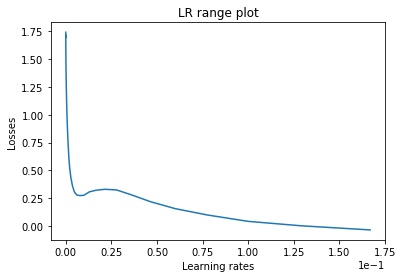

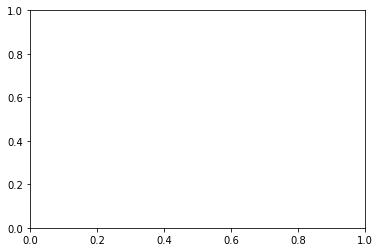

In [26]:
# %load main.py
from utilities import make_log_folder
import shutil
from testing_functions import run_some_linear_models,run_nn
from IPython import get_ipython
import time
if __name__ == '__main__':
    make_log_folder(log_folder_name="logs")
    # run_linear_model_with_under_and_over_sampling(file_name="socfb-American75", force_recreate_datasets=False, write_train_val_test=False)
    ## result: linear_regression: Accuracy=52.527%, MSE=0.492, MAE=0.558, MRE=0.2
    #run_some_linear_models(file_name="fb-pages-food", force_recreate_datasets=True, write_train_val_test=False)
    ## result: linear_regression: Accuracy = 69.712 %, MSE = 0.248, MAE = 0.393, MRE = 0.16
    
    
    #graph = ["as-internet","socfb-American75","socfb-OR"]
    """
    run portion = 0.2, method = top_degrees, you can get many possiable results(stored in log files) like below, 
    which doesn't make sense', since all the data is the same for every run, 
    then all the accuracy and mae should also be same
    {'acc': '6.6667', 'mse': '4.1998', 'mae': '1.6779', 'mre': '0.376'}
    {'acc': '68.7586', 'mse': '0.1565', 'mae': '0.2963', 'mre': '0.0821'}
    {'acc': '60.1372', 'mse': '0.2511', 'mae': '0.3724', 'mre': '0.0997'}
    And other tests also have the same probelms when we deal with small graphs like inf-euroroad
    method can be either random or top_degrees
    """
    
    graph_name = 'fb-pages-food'
    run_nn(file_name=graph_name, force_recreate_datasets=True, portion = 0.2,
           method = "top_degrees",write_train_val_test=False)
    time.sleep(10)
    cmd = "rm -r " + "../output/nn_return/{}".format(graph_name)
    os.system(cmd)
    
    
  
    """
    graph = ['fb-pages-food']
    portions = [0.2,0.3,0.4,0.5,0.6,0.7,0.8]
    methods = ['random','top_degree']
    Acc_r = []
    Mae_r = []
    Acc_t = []
    Mae_t = []
    
    for i in range(8):
        for graph_name in graph:
            for method in methods:
                tem_acc_r = []
                tem_mae_r = []
                tem_acc_t = []
                tem_mae_t = []
                for portion in portions:
                    if(method == 'random'):
                         get_ipython().magic('reset -sf')
                         run_nn(Acc = tem_acc_r,Mae = tem_mae_r,file_name=graph_name, force_recreate_datasets=True, portion = portion,method = method,write_train_val_test=False)
                         shutil.rmtree("../output/nn_return/{}".format(graph_name))# just remove return
                         time.sleep(50)
                    else:
                         get_ipython().magic('reset -sf')
                         run_nn(Acc = tem_acc_t,Mae = tem_mae_t,file_name=graph_name, force_recreate_datasets=True, portion = portion,method = method,write_train_val_test=False)
                         shutil.rmtree("../output/nn_return/{}".format(graph_name))# just remove return
                         time.sleep(50)
                if(method == 'random'):
                    Acc_r.append(tem_acc_r)
                    Mae_r.append(tem_mae_r)
                else:
                    Acc_t.append(tem_acc_t)
                    Mae_t.append(tem_mae_t)
  
                    
    ## result: nn: Accuracy 41.268%,  MSE = 0.225, MAE = 0.37, MRE = 0.14
    
    """

256